## Purpose of Notebook

For this project, i will be looking at the [Medical Cost Data Set](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) from Kaggle. This dataset contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.

For the project's regression problem, i am interested in how these different characteristics relate to the total medical cost. It's a continuous, positive number, which makes it a good candidate for a linear regression. For this project, i will construct the best possible predictive model for the cost, given some information about the patient. Predicting medical costs is an important task because it allows hospitals to predict revenue and plan necessary procedures needed by its patient population.

In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load in the insurance dataset
insurance = pd.read_csv("insurance.csv")

## Exploring The Dataset


In [3]:
# Columns in the dataset
insurance.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

The `charges` column is our outcome, while everything else are the potential predictors to use in the model

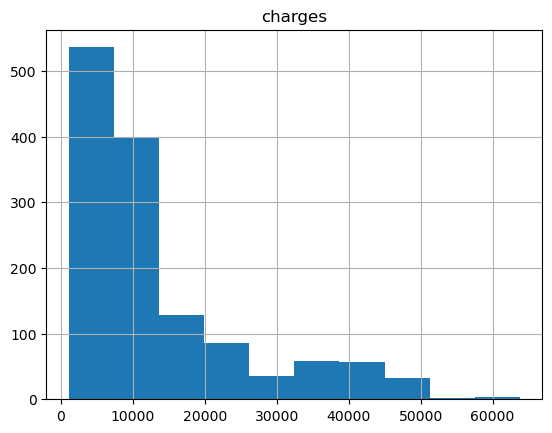

In [8]:
insurance.hist('charges');

The `charges` column is highly skewed to the right. Extremely costly insurance charges are less common than extremely small ones. This makes it unlikely that the errors in the model will truly be centered at zero. It might be worth it to log-transform the outcome.

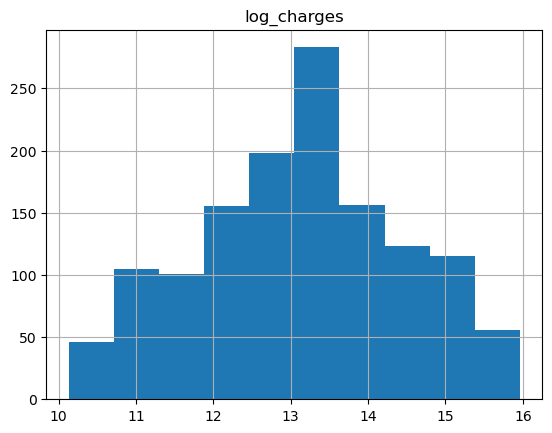

In [10]:
insurance["log_charges"] = np.log2(insurance["charges"])

insurance.hist("log_charges");

The log-transformed `charges` values are more centered, which is what was required. This makes it more likely that the errors will be unbiased.

In [18]:
# Checking the correlation between the continuous columns in the insurance data
insurance.corr()

,age,bmi,children,charges,log_charges
age,1.000000,0.109272,0.042469,0.299008,0.527834
bmi,0.109272,1.000000,0.012759,0.198341,0.132669
children,0.042469,0.012759,1.000000,0.067998,0.161336
charges,0.299008,0.198341,0.067998,1.000000,0.892964
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000


## Comments on correlation

`age` has 30% correlation with `charges`, `bmi` has 19.8% correlation, and number of `children` has 6.7% correlation.

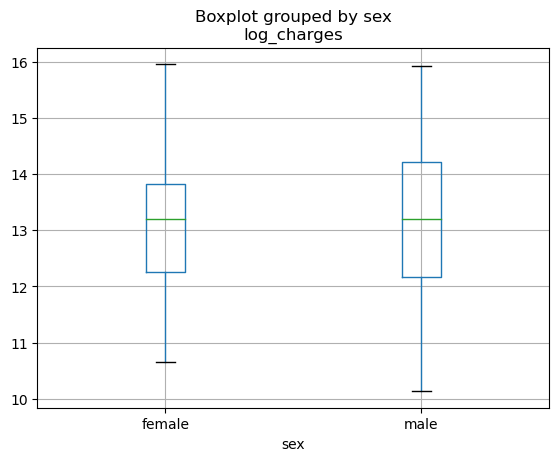

In [20]:
insurance.boxplot(column=['log_charges'], by='sex');

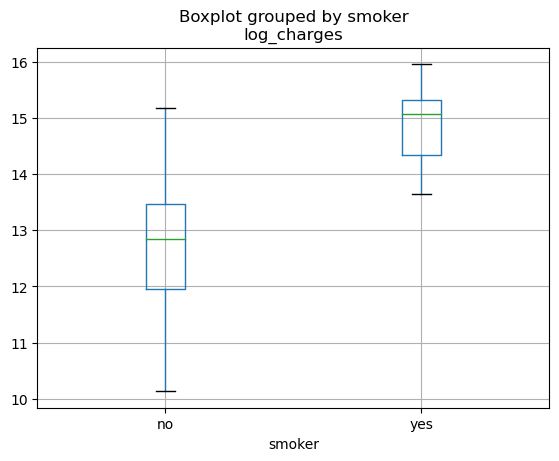

In [22]:
insurance.boxplot(column = ["log_charges"], by = "smoker");

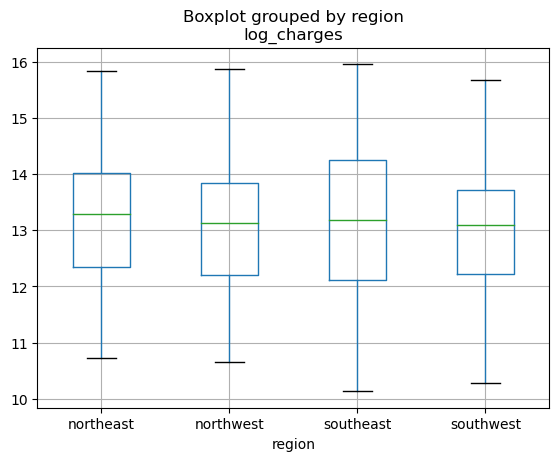

In [23]:
insurance.boxplot(column = ["log_charges"], by = "region");

Males seem to have a wider distribution of charges compared to women. Smokers have much higher costs than non-smokers. There doesn't seem to be many appreciable differences between regions.<br>

<br> Based on the univariate relationships shown above, age, bmi and smoker are positively associated with higher charges. We'll include these predictors in our final model.

## Dividing The Data


In [24]:
# Splitting the data up into a training and test set
insurance["is_smoker"] = (insurance["smoker"] == "yes")
X = insurance[["age", "bmi", "is_smoker"]]
y = insurance["log_charges"]

# 75% for training set, 25% for test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, 
                                                    random_state = 1)

## Build The Model


In [25]:
# Training and checking model performance on training set
insurance_model = LinearRegression()
insurance_model.fit(X_train, y_train)

LinearRegression()

In [26]:
# Get predicted values by model
y_pred = insurance_model.predict(X_train)

# MSE on the log scale for the insurance charges
mean_squared_error(y_train, y_pred)

0.4546665339270644

In [27]:
# MSE on the original scale for the insurance charges
np.exp(mean_squared_error(y_train, y_pred))

1.575647870310887

In [28]:
r2_score(y_train, y_pred)

0.7421118855283421

The training MSE for the model is 0.454 and is 1.57 on the original scale. The r2 indicates that the model can explain 74% of the variation in the log-insurance charges. These preliminary results are promising.

## Residual Diagnostics


/home/talha/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


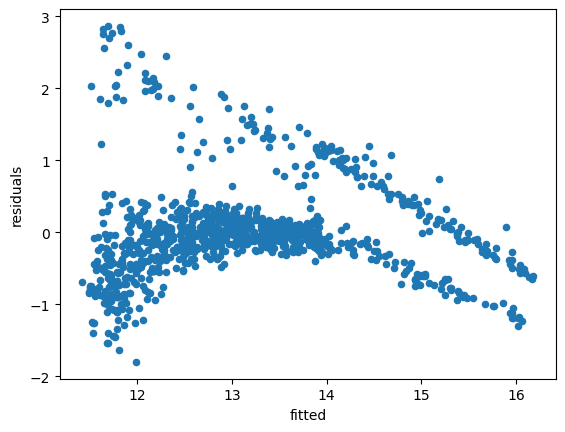

In [30]:
# Quick visual check of residuals
check = pd.DataFrame()
check["residuals"] = y_train - y_pred
check["fitted"] = y_pred

check.plot.scatter(x = "fitted", y = "residuals");

The residuals suggest some violations to the assumptions of linear regression. As fitted values get larger, the residuals trend downward. We expect an even band, centered around zero. This does not necessarily make the model predictions unusable, but it puts into question the linear regression assumptions.



## Interpreting The Model


In [31]:
# Getting the non-intercept coefficients
insurance_model.coef_

array([0.04892865, 0.01523672, 2.23063344])

In [45]:
(np.exp(insurance_model.coef_)-1)*100

array([  5.01454169,   1.53533902, 830.57588461])

- A year increase in the subject is associated with a 0.04 increase in the log charges, holding smoking status and bmi constant. About a 5% increase in the charges on the regular scale.

- A unit increase in the subject BMI is associated with a 0.01 increase in the log charges, holding smoking status and age constant. About a 1.5% increase in the charges on the regular scale.

- A smoker is associated with a 2.23 increase in the log charges, holding age and bmi constant. About a 830% increase in the charges on the regular scale.



## Final Model Evaluation


In [46]:
# Getting MSE on test model
test_pred = insurance_model.predict(X_test)

mean_squared_error(y_test, test_pred)

0.4355350875308212

In [47]:
# Putting the outcome (in log-terms) back into the original scale
np.exp(mean_squared_error(y_test, test_pred))

1.5457899706350982

## Drawing Conclusions
The test MSE was about 0.435, while the training MSE was about 0.454. In this case, the two errors match up pretty well, so it can be concluded that the model is not overfit. The residuals suggest that the model is predicting much lower costs for subjects who were actually charged much higher. Therefore the model struggles with these higher costs. As a whole, the model predictions are too conservative.

We might improve the model by including more complex terms in the regression, such as interactions or quadratic terms.
